## Problem

My goal for this project was to evaluate stats in the NFL and predict the outcome of an NFL game.

## Data

For this project, I was able to find an NFL database that consist of stats from 2009 to 2015. This db was downloaded from BurntSushi github page to PostGreSQL. 

https://github.com/BurntSushi/nfldb

This db consist of 5 tables and various team and player stats in each including final scores. 


## Cleaning

To make the data more accessible and easier to analyze, I used python to access the PostGreSQL database where the data was stored. 

Since the column names did not transfer over to the Python Dataframes, I had to manuall change the columns names from numerical to stat name to be more readable. 

In [19]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

try:
    conn = psycopg2.connect('dbname=nfl user=nfldb')
except: 
    print 'cannot connect'
cur = conn.cursor()

In [2]:
cur.execute("select * from game")
game = cur.fetchall()

games = []
for rows in game:
    games.append(rows)
    
games = pd.DataFrame(games)
games.head(1)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,2014122106,56403,2014-12-21 10:00:00-08:00,16,Sunday,2014,Regular,True,PIT,20,...,KC,12,3,3,0,6,0,0,2014-07-24 14:32:41.702371-07:00,2014-12-23 23:59:45.135816-08:00


In [3]:
games.columns = ['gsis_id','gamekey','start_time','week','day_of_week','season_year',
                 'season_type','finished','home_team','home_score','home_score_q1',
                 'home_score_q2','home_score_q3','home_score_q4','home_score_q5',
                 'home_turnovers','away_team','away_score','away_score_q1','away_score_q2',
                 'away_score_q3','away_score_q4','away_score_q5','away_turnovers',
                 'time_inserted','time_updated']
games.head(1)

,gsis_id,gamekey,start_time,week,day_of_week,season_year,season_type,finished,home_team,home_score,...,away_team,away_score,away_score_q1,away_score_q2,away_score_q3,away_score_q4,away_score_q5,away_turnovers,time_inserted,time_updated
0,2014122106,56403,2014-12-21 10:00:00-08:00,16,Sunday,2014,Regular,True,PIT,20,...,KC,12,3,3,0,6,0,0,2014-07-24 14:32:41.702371-07:00,2014-12-23 23:59:45.135816-08:00


### Creating a column for the Winner

Since none of the tables shows the actual winners of each game, I created an additional column that shows the winner based on the final score of the game. To do so, I had to zip the home team and score and away team and score. 

In [4]:
home_score = zip(games['home_team'], games['home_score'])
away_score = zip(games['away_team'], games['away_score'])

winner = []
for k, v in zip(home_score, away_score):
    if k[1] > v[1]:
        winner.append(k[0])
    elif k[1] < v[1]:
        winner.append(v[0])
    else:
        winner.append('tie')
        
games['winner'] = winner

# Final Dataset

After subsetting and concatenating the play_players, games and drives tables, so that the home and away stats will be on a single row, I dropped columns that had high correlation and vulnerable to overfit. 

- Column names with X is for home teams
- Column names with Y is for away teams

The winner column has been dummified to show 1 if winner is the home team and 0 if winner is away team

In [5]:
finalDF = pd.read_csv('../Capstone/final_df_2_beforeDummy.csv')
finalDF.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
finalDF.head(3)

,gsis_id,winner,team_x,team_y,score_x,score_y,week,day_of_week,defense_ast_x,defense_ffum_x,...,receiving_yac_yds_y,receiving_yds_y,rushing_att_y,rushing_tds_y,rushing_twopta_y,rushing_twoptm_y,rushing_twoptmissed_y,rushing_yds_y,turnovers_y,location_y
0,2009091000,PIT,PIT,TEN,13,10,1,Thursday,25,1,...,88,244,25,0,0,0,0,86,2,0
1,2009091300,ATL,ATL,MIA,19,7,1,Sunday,5,3,...,88,176,22,0,0,0,0,96,0,0
2,2009091301,BAL,BAL,KC,38,24,1,Sunday,10,1,...,82,177,17,0,0,0,0,29,0,0


### Below plot shows the total wins by team from 2009 to 2015

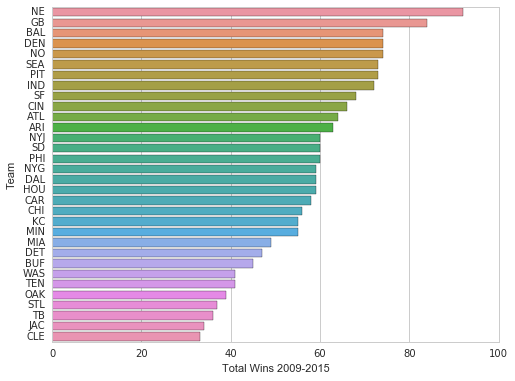

In [79]:
most_wins = finalDF.winner.value_counts()
most_wins = pd.DataFrame(most_wins).reset_index()
most_wins.columns = ['Team','Total Wins']

sns.set(style='whitegrid')
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
sns.barplot(x='Total Wins', y='Team', data=most_wins,)
ax.set(xlabel='Total Wins 2009-2015', ylabel='Team')

plt.show()

# Model Selection

I chose to 5 models to run my dataset and predict the outcomes of each game. Here are the 5 I chose:
- Logistic Regression
- KNN
- Decision Tree
- Extra Tree
- Bagging Decision Tree
- Random Forest

To begin, I used train test to split my dataset up to be able to test my training model.

In [86]:
final_df_3 = pd.read_csv('../Capstone/final_df_3.csv')
final_df_3.drop(['Unnamed: 0'], axis=1, inplace=True)
final_df_3 = pd.get_dummies(final_df_3, columns=['team_x', 'team_y'])

In [90]:
from sklearn.cross_validation import train_test_split

y = final_df_3['winner']
X = final_df_3.iloc[:, 4:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic Regression
   - I started with Logistic regression with a gridsearch with both Lasso and Ridge regression to either remove or scale down some of the features.
   - After running the model, ridge regression with the scaled down feature turned out to have the best parameter.

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

logreg = LogisticRegression()
logreg_params = {
    'penalty':['l1','l2'],
    'class_weight':[None, 'balanced' ],
    'solver': ['liblinear']
}

In [92]:
logreg_gs = GridSearchCV(LogisticRegression(), logreg_params, cv=5, verbose=1)
logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [93]:
logreg_best = logreg_gs.best_estimator_
print logreg_best
print logreg_gs.best_params_
print logreg_gs.best_score_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'penalty': 'l2', 'solver': 'liblinear', 'class_weight': None}
0.927035330261


In [95]:
from sklearn import metrics

lr_gs_predicted = logreg_gs.predict(X_test)
print metrics.confusion_matrix(y_test, lr_gs_predicted)
print metrics.classification_report(y_test, lr_gs_predicted)

[[212  20]
 [ 16 310]]
             precision    recall  f1-score   support

          0       0.93      0.91      0.92       232
          1       0.94      0.95      0.95       326

avg / total       0.94      0.94      0.94       558



In [138]:
#logreg_gs.predict_proba(X_test)[:, 1]
lr_prob

array([[  1.00591236e-01,   8.99408764e-01],
       [  2.15004208e-05,   9.99978500e-01],
       [  7.91399296e-02,   9.20860070e-01],
       ..., 
       [  2.32906091e-05,   9.99976709e-01],
       [  1.97219338e-01,   8.02780662e-01],
       [  9.99998901e-01,   1.09890150e-06]])

### KNN
   - I tested KNN next and the accuracy score did not turn out very well compared to Logistic Regression

In [97]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors':range(1,50),
    'weights':['uniform','distance']
}

In [98]:
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1)
knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   28.8s
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:   32.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [99]:
knn_best = knn_gs.best_estimator_
print knn_best
print knn_gs.best_params_
print knn_gs.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=37, p=2,
           weights='uniform')
{'n_neighbors': 37, 'weights': 'uniform'}
0.73886328725


In [100]:
knn_gs_predicted = knn_gs.predict(X_test)
print metrics.confusion_matrix(y_test, knn_gs_predicted)
print metrics.classification_report(y_test, knn_gs_predicted)

[[137  95]
 [ 67 259]]
             precision    recall  f1-score   support

          0       0.67      0.59      0.63       232
          1       0.73      0.79      0.76       326

avg / total       0.71      0.71      0.71       558



### Decision Tree
   - I then modeled the dataset with Decision Tree and the score was best with a depth of 4. Also added a few ensemble methods and best best score came out to be Extra Tree. 

In [121]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

dtc_params = {
    'max_depth':[None,1,2,3,4,5,10,20],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25]
}

In [122]:
dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:   13.5s
[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:   17.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [123]:
dtc_best = dtc_gs.best_estimator_
print dtc_best
print dtc_gs.best_params_
print dtc_gs.best_score_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
{'max_features': None, 'min_samples_split': 2, 'max_depth': 4}
0.837173579109


In [105]:
dtc_gs_predicted = dtc_gs.predict(X_test)
print metrics.confusion_matrix(y_test, dtc_gs_predicted)
print metrics.classification_report(y_test, dtc_gs_predicted)

[[176  56]
 [ 31 295]]
             precision    recall  f1-score   support

          0       0.85      0.76      0.80       232
          1       0.84      0.90      0.87       326

avg / total       0.84      0.84      0.84       558



### Bagging Decision Tree

In [106]:
from sklearn.ensemble import BaggingClassifier
bdtc = BaggingClassifier(DecisionTreeClassifier())

params = {'base_estimator__max_depth': [3,5,10,20],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10, 20],
         }

In [107]:
bdt_gs = GridSearchCV(bdtc, params, n_jobs=-1, cv=5)
bdt_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.5, 0.7, 1.0], 'max_samples': [0.5, 0.7, 1.0], 'base_estimator__max_depth': [3, 5, 10, 20], 'n_estimators': [2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [108]:
bdt_best = bdt_gs.best_estimator_
print bdt_best
print bdt_gs.best_params_
print bdt_gs.best_score_

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.7,
         max_samples=0.7, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)
{'max_features': 0.7, 'max_samples': 0.7, 'base_estimator__max_depth': 10, 'n_estimators': 20}
0.89247311828


In [109]:
bdt_gs_predicted = bdt_gs.predict(X_test)
print metrics.confusion_matrix(y_test, bdt_gs_predicted)
print metrics.classification_report(y_test, bdt_gs_predicted)

[[193  39]
 [ 22 304]]
             precision    recall  f1-score   support

          0       0.90      0.83      0.86       232
          1       0.89      0.93      0.91       326

avg / total       0.89      0.89      0.89       558



### Extra Tree Classifier

In [111]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

In [112]:
etc_gs = GridSearchCV(etc, dtc_params, cv=5, verbose=1)
etc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   21.8s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   33.9s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:   52.2s
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:   58.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [114]:
etc_best = etc_gs.best_estimator_
print etc_best
print etc_gs.best_params_
print etc_gs.best_score_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
{'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': None}
0.890937019969


In [113]:
etc_gs_predicted = etc_gs.predict(X_test)
print metrics.confusion_matrix(y_test, etc_gs_predicted)
print metrics.classification_report(y_test, etc_gs_predicted)

[[199  33]
 [ 24 302]]
             precision    recall  f1-score   support

          0       0.89      0.86      0.87       232
          1       0.90      0.93      0.91       326

avg / total       0.90      0.90      0.90       558



### Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [117]:
rfc_gs = GridSearchCV(RandomForestClassifier(), dtc_params, cv=5, verbose=1)
rfc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   14.9s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   25.5s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   39.8s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [118]:
rfc_best = rfc_gs.best_estimator_
print rfc_best
print rfc_gs.best_params_
print rfc_gs.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'max_features': None, 'min_samples_split': 15, 'max_depth': None}
0.885560675883


In [126]:
rfc_gs_predicted = rfc_gs.predict(X_test)
print metrics.confusion_matrix(y_test, rfc_gs_predicted)
print metrics.classification_report(y_test, rfc_gs_predicted)

[[193  39]
 [ 30 296]]
             precision    recall  f1-score   support

          0       0.87      0.83      0.85       232
          1       0.88      0.91      0.90       326

avg / total       0.88      0.88      0.88       558



In [129]:
lr_prob = logreg_gs.predict_proba(X_test)
bt_prob = bdt_gs.predict_proba(X_test)
et_prob = etc_gs.predict_proba(X_test)
rf_prob = rfc_gs.predict_proba(X_test)
dt_prob = dtc_gs.predict_proba(X_test)
knn_prob = knn_gs.predict_proba(X_test)


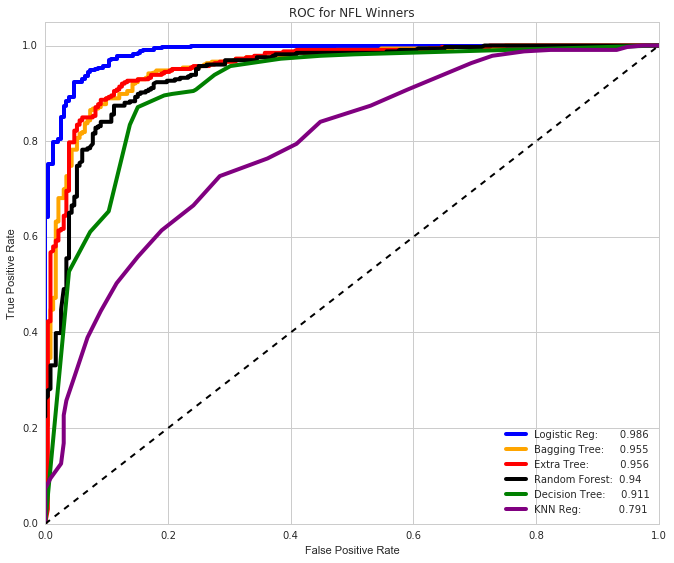

In [132]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(11,9),dpi=640)

fpr, tpr, thresholds = roc_curve(y_test, lr_prob[:,1])
auc1 = auc(fpr,tpr)
plt.plot(fpr, tpr, label="Logistic Reg:       {0}".format(round(auc1,3)),color='blue', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, bt_prob[:,1])
auc2 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Bagging Tree:     {0}".format(round(auc2,3)),color='orange', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, et_prob[:, 1])
auc3 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Extra Tree:          {0}".format(round(auc3,3)),color='red', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, rf_prob[:,1])
auc4 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Random Forest:  {0}".format(round(auc4,3)),color='black', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, dt_prob[:,1])
auc5 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="Decision Tree:     {0}".format(round(auc5,3)),color='green', linewidth=4)

fpr, tpr, thresholds = roc_curve(y_test, knn_prob[:,1])
auc6 = auc(fpr,tpr)
plt.plot(fpr, tpr, label="KNN Reg:            {0}".format(round(auc6,3)),color='purple', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC for NFL Winners') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

![emsemble](https://snag.gy/Hz3wTf.jpg)